### MOP Menggunakan algoritma Pareto Archived Evolution Strategy
#### Permasalahan ZDT1 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from numpy.lib.scimath import sqrt

def f1(x):
    if len(x.shape) == 1:  # only one x observation
        return x
    else:
        return x


def f2(x):
    if len(x.shape) == 1:  # only one x observation
        n = len(x)
        g = 1 + (9 * np.sum(x[1:]) / (n - 1))
        h = 1 - sqrt(f1(x) / g)
        return g * h
    else:
        n = x.shape[1]  # Number of elements in each row
        g = 1 + ((9 / (n - 1)) * np.sum(x[:, 1:], axis=1))
        h = 1 - sqrt(f1(x) / g.reshape(-1, 1))  # Ensure compatible shapes for broadcasting
        return g.reshape(-1, 1) * h


# return the relative fitness of an x value
# compared to the tournament x values: tourn_x,
# based off pareto dominance. Reward is based
# off strong and weak domination
def pareto_dominance(x, tourn_x):
    f_1 = f1(x)
    f_2 = f2(x)
    tourn_f1 = f1(tourn_x)
    tourn_f2 = f2(tourn_x)
    score = 0
    if len(tourn_x.shape) == 1:  # only one x observation
        if (f_1 <= tourn_f1).any() and (f_2 <= tourn_f2).any():  # atleast equal in any objectives
            score += 2
            if (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # strong dominance
                score += 2
        elif (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # weak domination
            score += 1
    else:
        for i in range(0, len(tourn_x)):
            for j in range(0, len(tourn_x)):
                if i == j:
                    continue
                for k in range(0, j):
                    pass

            for j in range(1, i):
                pass
            if (f_1 <= tourn_f1[i]).any() and (f_2 <= tourn_f2[i]).any():  # atleast equal in any objectives
                score += 2
                if (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # strong dominance
                    score += 2
            elif (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # weak domination
                score += 1

    return score


# Handles more than 2 parents
# Averaging Technique by taking mean of any parent values
def crossover_method_1(par):
    child = np.copy(par[0])
    for j in range(0, np.shape(par[0])[0]):
        child[j] = np.mean(par[:,j])
    return child


# Handles more than 2 parents
# 'intuitive' crossover by uniformly randomly
# inheriting genes from parents
def crossover_method_2(par):
    child = np.copy(par[0])
    n = np.shape(par[0])[0]
    # random indices from parents for child to inherit from
    random_nums = np.random.randint(low=0, high=len(par), size=n)
    for j in range(0, n):
        child[j] = par[random_nums[j]][j]
    return child


# classical Evolutionary Programming Mutation
# log-normal self adaptation
def mutate(par_val, par_sigma):
    n_x = len(par_val)  # number of variables
    tau = 1 / (np.sqrt(2 * np.sqrt(n_x)))
    tau_prime = 1 / (np.sqrt(2 * n_x))
    r = np.random.normal(0, 1, len(par_sigma))
    ch_sigma = par_sigma*np.exp(tau*r+tau_prime*r)
    r = np.random.normal(0, 1, len(par_sigma))
    ch_val = np.copy(par_val)+ch_sigma*r
    return ch_val, ch_sigma


# given a set of parents, their sigma, and cross_method
# produce two offspring, one through crossover only
# and the other through mutation after crossover
# choose the best for survival based off pareto-dominance
def reproduction(par, sigma, cross_method):
    if cross_method == 1:
        child_val = crossover_method_1(par)
        child_sigma = crossover_method_1(sigma)
    else:
        child_val = crossover_method_2(par)
        child_sigma = crossover_method_2(sigma)
    # mutate crossover offspring
    mut_child_val, mut_child_sigma = mutate(child_val, child_sigma)
    # get pareto-dominance between offspring
    f = pareto_dominance(child_val, mut_child_val)
    if f == 4:  # strong domination
        return child_val, child_sigma
    elif f == 2:  # weak domination
        r = np.random.uniform(0, 1, 1)
        if r < 0.5:  # randomly select winner
            return child_val, child_sigma
        else:
            return mut_child_val, mut_child_sigma
    else:  # no domination
        return mut_child_val, mut_child_sigma


# function has been parameterized for our problem, so no initial gen given
# size is # of individuals, var_count is number of variables for our problem
# max_distance is max euclidean similarity distance anyowed for solutions,
# max_iter is max iter of inner loop, archive_iter is outer loop -> larger
# iter for archive creates a bigger pareto-front
def evolutionary_strategy_pareto_algorithm(size, var_count, max_distance=2.0, max_iter=50,
                                           cross_method=1, par_count=2, archive_iter=30):

    lower_bound = [0] * var_count
    upper_bound = [1] * var_count
    bounds = [upper_bound, lower_bound]
    archive = []
    # outer loop
    for q in range(0, archive_iter):
        # create initial generation with strategy parameters
        init_gen = np.empty(shape=(size, var_count))
        init_sigma = np.empty(shape=(size, var_count))
        for i in range(0, var_count):
            init_sigma[:, i] = np.random.uniform(0.5, 5, size)
            init_gen[:, i] = np.random.uniform(0, 1, size)
        n, c = init_gen.shape
        tourn_size = int(0.05 * n)

        print("Archive {}".format(q + 1))
        gen = np.copy(init_gen)
        sigma = np.copy(init_sigma)
        # inner loop
        for k in range(0, max_iter):

            # random selection based off number of parents
            selected = []
            for i in range(0, par_count):
                selected.append(np.random.choice(range(0, n), n, replace=False))
            selected = np.asarray(selected).T
            ch_val = []
            ch_sigma = []
            # reproduce from parents
            '''
            if q % 2 == 0:
                cross_method = 1
            else:
                cross_method = 2
            '''
            for i in range(0, n):
                c_v, c_s = reproduction(gen[selected[i]], sigma[selected[i]], cross_method)
                ch_val.append(c_v)
                ch_sigma.append(c_s)

            ch_val = np.asarray(ch_val)
            ch_sigma = np.asarray(ch_sigma)
            # check bounds of offspring
            for i in range(0, n):
                for j in range(0, c):
                    if ch_val[i][j] > bounds[0][j]:
                        ch_val[i][j] = bounds[0][j]
                        ch_sigma[i][j] *= .90
                    elif ch_val[i][j] < bounds[1][j]:
                        ch_val[i][j] = bounds[1][j]
                        ch_sigma[i][j] *= .90

            # combine offspring with parents
            parents_offspring_val = np.vstack((gen, ch_val))
            parents_offspring_sigma = np.vstack((sigma, ch_sigma))
            ind = list(range(0, 2*n))
            rel_fit = []
            # compute relative fitness
            for i in range(0, 2*n):
                tourn = np.random.choice(ind[0:i]+ind[(i+1):], tourn_size)
                rel_fit.append(pareto_dominance(parents_offspring_val[i], parents_offspring_val[tourn]))

            if q != 0:  # not first iteration of outer loop
                # loop over each member in archive
                for arch in archive:
                    for i in range(0, 2*n):
                        # calculate euclidean distance
                        dist = np.linalg.norm(arch-parents_offspring_val[i])
                        # if their distance is smany -> they're too close,
                        # larger the max distance the more spread out solutions become
                        if dist <= max_distance:
                            # penalize fitness down to 25%
                            rel_fit[i] *= 0.25

            # sort individuals based on relative fitness
            rel_fit = np.asarray(rel_fit)
            sorted_ind = np.asarray(ind)[np.argsort(-rel_fit)]

            # use elitism to take the best half from pooled
            # parents and offspring
            gen = parents_offspring_val[sorted_ind[0:n]]
            sigma = parents_offspring_sigma[sorted_ind[0:n]]

            # calculate best for printing out information
            fit_f1 = f1(gen)
            fit_f2 = f2(gen)
            fit_best_f1 = np.min(fit_f1)
            fit_mean_f1 = np.mean(fit_f1)
            fit_best_f2 = np.min(fit_f2)
            fit_mean_f2 = np.mean(fit_f2)
            msg = "GENERATION {}:\n" \
                  " F1: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n"\
                  " F2: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n".format(k, fit_best_f1, fit_mean_f1, fit_best_f2, fit_mean_f2)
            print(msg)

        # update archive
        if q != 0:
            # loop over every individual in surviving generation
            for j in range(0, len(gen)):
                # indices of members in archive that are dominated by
                # the current individual
                ind_del = []
                f1_arch = f1(np.asarray(archive))
                f2_arch = f2(np.asarray(archive))
                dominated = False
                for i in range(0, len(archive)):
                    # individual strongly dominates member of archive
                    if (f1_arch[i] > fit_f1[j]).any() and (f2_arch[i] > fit_f2[j]).any():
                        ind_del.append(i)  # add member index for deletion
                    # individual is strongly dominated by member
                    elif (f1_arch[i] < fit_f1[j]).any() and (f2_arch[i] < fit_f2[j]).any():
                        dominated = True
                if len(ind_del) != 0:
                    # delete members that are strongly dominated
                    for index in sorted(ind_del, reverse=True):
                        del archive[index]
                if not dominated:  # weakly dominates members of archive
                    archive.append(gen[j])

        else:  # if first iteration of outer loop, just add best solution from gen
            archive.append(gen[0])
    print(archive)
    return np.asarray(archive)

arch = evolutionary_strategy_pareto_algorithm(size=100, var_count=30, max_distance=0.75,
                                              max_iter=40, cross_method=1, par_count=3,
                                              archive_iter=50)

Archive 1
GENERATION 0:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.48271088276286894
 F2: 
  Best Fit: 1.700844136249243, Mean Fit: 3.879994887426593

GENERATION 1:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.46525322913660966
 F2: 
  Best Fit: 1.8071633751598226, Mean Fit: 3.7945935500991657

GENERATION 2:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4536612309648423
 F2: 
  Best Fit: 1.4628317018139434, Mean Fit: 3.7044629521107413

GENERATION 3:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.43920514905863434
 F2: 
  Best Fit: 1.430844935182129, Mean Fit: 3.652051623618189

GENERATION 4:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.430093015451763
 F2: 
  Best Fit: 1.512668983193286, Mean Fit: 3.571133693041558

GENERATION 5:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.42788545149023516
 F2: 
  Best Fit: 1.9612259351864718, Mean Fit: 3.5815290376642492

GENERATION 6:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4131143798873947
 F2: 
  Best Fit: 1.1174446796691422, Mean Fit: 3.497497460459381

GENERATION 7:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4215687

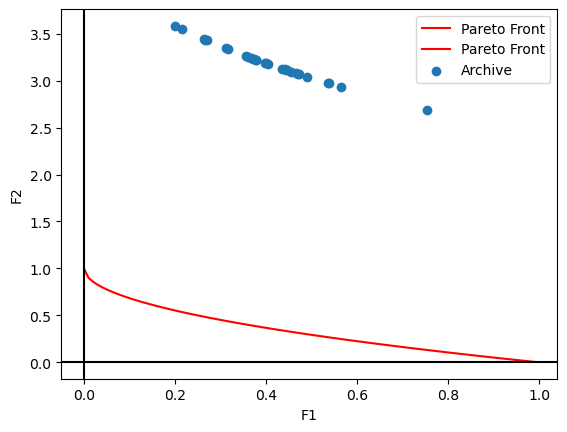

In [31]:
x = np.arange(0, 1, 0.01)
pareto_front_values = []

for xi in x:
    f1_val, f2_val = f1(np.array([xi, 0])), f2(np.array([xi, 0]))
    pareto_front_values.append([f1_val, f2_val])

pareto_front_values = np.array(pareto_front_values)
f1_values = pareto_front_values[:, 0]
f2_values = pareto_front_values[:, 1]

f1_arch = f1(arch)
f2_arch = f2(arch)

plt.plot(f1_values, f2_values, c="red", label="Pareto Front")  
plt.scatter(f1_arch, f2_arch, label="Archive")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.show()


Kesimpulan : Algoritma ini menggunakan max archive iterasi 50 dengan max distance 0.75 dengan 30-variable problem masih value archive masih kurang maximal untuk mendekati pareto front yang ada

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from numpy.lib.scimath import sqrt

def f1(x):
    if len(x.shape) == 1:  # only one x observation
        return x
    else:
        return x


def f2(x):
    if len(x.shape) == 1:  # only one x observation
        n = len(x)
        g = 1 + (9 * np.sum(x[1:]) / (n - 1))
        h = 1 - sqrt(f1(x) / g)
        return g * h
    else:
        n = x.shape[1]  
        g = 1 + ((9 / (n - 1)) * np.sum(x[:, 1:], axis=1))
        h = 1 - sqrt(f1(x) / g.reshape(-1, 1)) 
        return g.reshape(-1, 1) * h


# return the relative fitness of an x value
# compared to the tournament x values: tourn_x,
# based off pareto dominance. Reward is based
# off strong and weak domination
def pareto_dominance(x, tourn_x):
    f_1 = f1(x)
    f_2 = f2(x)
    tourn_f1 = f1(tourn_x)
    tourn_f2 = f2(tourn_x)
    score = 0
    if len(tourn_x.shape) == 1:  # only one x observation
        if (f_1 <= tourn_f1).any() and (f_2 <= tourn_f2).any():  # atleast equal in any objectives
            score += 2
            if (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # strong dominance
                score += 2
        elif (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # weak domination
            score += 1
    else:
        for i in range(0, len(tourn_x)):
            for j in range(0, len(tourn_x)):
                if i == j:
                    continue
                for k in range(0, j):
                    pass

            for j in range(1, i):
                pass
            if (f_1 <= tourn_f1[i]).any() and (f_2 <= tourn_f2[i]).any():  # atleast equal in any objectives
                score += 2
                if (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # strong dominance
                    score += 2
            elif (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # weak domination
                score += 1

    return score


# Handles more than 2 parents
# Averaging Technique by taking mean of any parent values
def crossover_method_1(par):
    child = np.copy(par[0])
    for j in range(0, np.shape(par[0])[0]):
        child[j] = np.mean(par[:,j])
    return child


# Handles more than 2 parents
# 'intuitive' crossover by uniformly randomly
# inheriting genes from parents
def crossover_method_2(par):
    child = np.copy(par[0])
    n = np.shape(par[0])[0]
    # random indices from parents for child to inherit from
    random_nums = np.random.randint(low=0, high=len(par), size=n)
    for j in range(0, n):
        child[j] = par[random_nums[j]][j]
    return child


# classical Evolutionary Programming Mutation
# log-normal self adaptation
def mutate(par_val, par_sigma):
    n_x = len(par_val)  # number of variables
    tau = 1 / (np.sqrt(2 * np.sqrt(n_x)))
    tau_prime = 1 / (np.sqrt(2 * n_x))
    r = np.random.normal(0, 1, len(par_sigma))
    ch_sigma = par_sigma*np.exp(tau*r+tau_prime*r)
    r = np.random.normal(0, 1, len(par_sigma))
    ch_val = np.copy(par_val)+ch_sigma*r
    return ch_val, ch_sigma


# given a set of parents, their sigma, and cross_method
# produce two offspring, one through crossover only
# and the other through mutation after crossover
# choose the best for survival based off pareto-dominance
def reproduction(par, sigma, cross_method):
    if cross_method == 1:
        child_val = crossover_method_1(par)
        child_sigma = crossover_method_1(sigma)
    else:
        child_val = crossover_method_2(par)
        child_sigma = crossover_method_2(sigma)
    # mutate crossover offspring
    mut_child_val, mut_child_sigma = mutate(child_val, child_sigma)
    # get pareto-dominance between offspring
    f = pareto_dominance(child_val, mut_child_val)
    if f == 4:  # strong domination
        return child_val, child_sigma
    elif f == 2:  # weak domination
        r = np.random.uniform(0, 1, 1)
        if r < 0.5:  # randomly select winner
            return child_val, child_sigma
        else:
            return mut_child_val, mut_child_sigma
    else:  # no domination
        return mut_child_val, mut_child_sigma


# function has been parameterized for our problem, so no initial gen given
# size is # of individuals, var_count is number of variables for our problem
# max_distance is max euclidean similarity distance anyowed for solutions,
# max_iter is max iter of inner loop, archive_iter is outer loop -> larger
# iter for archive creates a bigger pareto-front
def evolutionary_strategy_pareto_algorithm(size, var_count, max_distance=2.0, max_iter=50,
                                           cross_method=1, par_count=2, archive_iter=30):

    lower_bound = [0] * var_count
    upper_bound = [1] * var_count
    bounds = [upper_bound, lower_bound]
    archive = []
    # outer loop
    for q in range(0, archive_iter):
        # create initial generation with strategy parameters
        init_gen = np.empty(shape=(size, var_count))
        init_sigma = np.empty(shape=(size, var_count))
        for i in range(0, var_count):
            init_sigma[:, i] = np.random.uniform(0.5, 5, size)
            init_gen[:, i] = np.random.uniform(0, 1, size)
        n, c = init_gen.shape
        tourn_size = int(0.05 * n)

        print("Archive {}".format(q + 1))
        gen = np.copy(init_gen)
        sigma = np.copy(init_sigma)
        # inner loop
        for k in range(0, max_iter):

            # random selection based off number of parents
            selected = []
            for i in range(0, par_count):
                selected.append(np.random.choice(range(0, n), n, replace=False))
            selected = np.asarray(selected).T
            ch_val = []
            ch_sigma = []
            # reproduce from parents
            '''
            if q % 2 == 0:
                cross_method = 1
            else:
                cross_method = 2
            '''
            for i in range(0, n):
                c_v, c_s = reproduction(gen[selected[i]], sigma[selected[i]], cross_method)
                ch_val.append(c_v)
                ch_sigma.append(c_s)

            ch_val = np.asarray(ch_val)
            ch_sigma = np.asarray(ch_sigma)
            # check bounds of offspring
            for i in range(0, n):
                for j in range(0, c):
                    if ch_val[i][j] > bounds[0][j]:
                        ch_val[i][j] = bounds[0][j]
                        ch_sigma[i][j] *= .90
                    elif ch_val[i][j] < bounds[1][j]:
                        ch_val[i][j] = bounds[1][j]
                        ch_sigma[i][j] *= .90

            # combine offspring with parents
            parents_offspring_val = np.vstack((gen, ch_val))
            parents_offspring_sigma = np.vstack((sigma, ch_sigma))
            ind = list(range(0, 2*n))
            rel_fit = []
            # compute relative fitness
            for i in range(0, 2*n):
                tourn = np.random.choice(ind[0:i]+ind[(i+1):], tourn_size)
                rel_fit.append(pareto_dominance(parents_offspring_val[i], parents_offspring_val[tourn]))

            if q != 0:  # not first iteration of outer loop
                # loop over each member in archive
                for arch in archive:
                    for i in range(0, 2*n):
                        # calculate euclidean distance
                        dist = np.linalg.norm(arch-parents_offspring_val[i])
                        # if their distance is smany -> they're too close,
                        # larger the max distance the more spread out solutions become
                        if dist <= max_distance:
                            # penalize fitness down to 25%
                            rel_fit[i] *= 0.25

            # sort individuals based on relative fitness
            rel_fit = np.asarray(rel_fit)
            sorted_ind = np.asarray(ind)[np.argsort(-rel_fit)]

            # use elitism to take the best half from pooled
            # parents and offspring
            gen = parents_offspring_val[sorted_ind[0:n]]
            sigma = parents_offspring_sigma[sorted_ind[0:n]]

            # calculate best for printing out information
            fit_f1 = f1(gen)
            fit_f2 = f2(gen)
            fit_best_f1 = np.min(fit_f1)
            fit_mean_f1 = np.mean(fit_f1)
            fit_best_f2 = np.min(fit_f2)
            fit_mean_f2 = np.mean(fit_f2)
            msg = "GENERATION {}:\n" \
                  " F1: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n"\
                  " F2: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n".format(k, fit_best_f1, fit_mean_f1, fit_best_f2, fit_mean_f2)
            print(msg)

        # update archive
        if q != 0:
            # loop over every individual in surviving generation
            for j in range(0, len(gen)):
                # indices of members in archive that are dominated by
                # the current individual
                ind_del = []
                f1_arch = f1(np.asarray(archive))
                f2_arch = f2(np.asarray(archive))
                dominated = False
                for i in range(0, len(archive)):
                    # individual strongly dominates member of archive
                    if (f1_arch[i] > fit_f1[j]).any() and (f2_arch[i] > fit_f2[j]).any():
                        ind_del.append(i)  # add member index for deletion
                    # individual is strongly dominated by member
                    elif (f1_arch[i] < fit_f1[j]).any() and (f2_arch[i] < fit_f2[j]).any():
                        dominated = True
                if len(ind_del) != 0:
                    # delete members that are strongly dominated
                    for index in sorted(ind_del, reverse=True):
                        del archive[index]
                if not dominated:  # weakly dominates members of archive
                    archive.append(gen[j])

        else:  # if first iteration of outer loop, just add best solution from gen
            archive.append(gen[0])
    print(archive)
    return np.asarray(archive)

arch = evolutionary_strategy_pareto_algorithm(size=100, var_count=30, max_distance=0.75,
                                              max_iter=40, cross_method=1, par_count=3,
                                              archive_iter=300)

Archive 1
GENERATION 0:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4736284721982143
 F2: 
  Best Fit: 1.54516607053163, Mean Fit: 3.818235566557379

GENERATION 1:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4616836860669746
 F2: 
  Best Fit: 1.8372092480725817, Mean Fit: 3.778598466033957

GENERATION 2:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4441492219695868
 F2: 
  Best Fit: 1.4183680014312634, Mean Fit: 3.699831840844062

GENERATION 3:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4362941820318647
 F2: 
  Best Fit: 1.6503349897732693, Mean Fit: 3.628424565047319

GENERATION 4:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.43057292076416115
 F2: 
  Best Fit: 1.5770585592967323, Mean Fit: 3.5688547377778934

GENERATION 5:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4237818794232332
 F2: 
  Best Fit: 1.7107236703850615, Mean Fit: 3.535807191701282

GENERATION 6:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4281845383897174
 F2: 
  Best Fit: 1.8465651964299006, Mean Fit: 3.54581603889684

GENERATION 7:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.42532375539

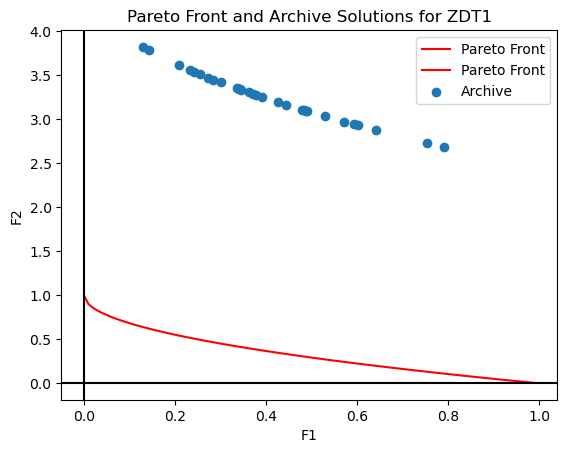

In [14]:
x = np.arange(0, 1, 0.01)
pareto_front_values = []

for xi in x:
    f1_val, f2_val = f1(np.array([xi, 0])), f2(np.array([xi, 0]))
    pareto_front_values.append([f1_val, f2_val])

pareto_front_values = np.array(pareto_front_values)
f1_values = pareto_front_values[:, 0]
f2_values = pareto_front_values[:, 1]

f1_arch = f1(arch)
f2_arch = f2(arch)

plt.plot(f1_values, f2_values, c="red", label="Pareto Front")  
plt.scatter(f1_arch, f2_arch, label="Archive")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.title("Pareto Front and Archive Solutions for ZDT1")
plt.show()

Kesimpulan : Algoritma ini menggunakan max archive iterasi 300 dengan max distance 0.75 dengan 30-variable problem masih value archive masih kurang maximal untuk mendekati pareto front yang ada

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from numpy.lib.scimath import sqrt

def f1(x):
    if len(x.shape) == 1:  # only one x observation
        return x
    else:
        return x


def f2(x):
    if len(x.shape) == 1:  # only one x observation
        n = len(x)
        g = 1 + (9 * np.sum(x[1:]) / (n - 1))
        h = 1 - sqrt(f1(x) / g)
        return g * h
    else:
        n = x.shape[1]  
        g = 1 + ((9 / (n - 1)) * np.sum(x[:, 1:], axis=1))
        h = 1 - sqrt(f1(x) / g.reshape(-1, 1)) 
        return g.reshape(-1, 1) * h


# return the relative fitness of an x value
# compared to the tournament x values: tourn_x,
# based off pareto dominance. Reward is based
# off strong and weak domination
def pareto_dominance(x, tourn_x):
    f_1 = f1(x)
    f_2 = f2(x)
    tourn_f1 = f1(tourn_x)
    tourn_f2 = f2(tourn_x)
    score = 0
    if len(tourn_x.shape) == 1:  # only one x observation
        if (f_1 <= tourn_f1).any() and (f_2 <= tourn_f2).any():  # atleast equal in any objectives
            score += 2
            if (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # strong dominance
                score += 2
        elif (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # weak domination
            score += 1
    else:
        for i in range(0, len(tourn_x)):
            for j in range(0, len(tourn_x)):
                if i == j:
                    continue
                for k in range(0, j):
                    pass

            for j in range(1, i):
                pass
            if (f_1 <= tourn_f1[i]).any() and (f_2 <= tourn_f2[i]).any():  # atleast equal in any objectives
                score += 2
                if (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # strong dominance
                    score += 2
            elif (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # weak domination
                score += 1

    return score


# Handles more than 2 parents
# Averaging Technique by taking mean of any parent values
def crossover_method_1(par):
    child = np.copy(par[0])
    for j in range(0, np.shape(par[0])[0]):
        child[j] = np.mean(par[:,j])
    return child


# Handles more than 2 parents
# 'intuitive' crossover by uniformly randomly
# inheriting genes from parents
def crossover_method_2(par):
    child = np.copy(par[0])
    n = np.shape(par[0])[0]
    # random indices from parents for child to inherit from
    random_nums = np.random.randint(low=0, high=len(par), size=n)
    for j in range(0, n):
        child[j] = par[random_nums[j]][j]
    return child


# classical Evolutionary Programming Mutation
# log-normal self adaptation
def mutate(par_val, par_sigma):
    n_x = len(par_val)  # number of variables
    tau = 1 / (np.sqrt(2 * np.sqrt(n_x)))
    tau_prime = 1 / (np.sqrt(2 * n_x))
    r = np.random.normal(0, 1, len(par_sigma))
    ch_sigma = par_sigma*np.exp(tau*r+tau_prime*r)
    r = np.random.normal(0, 1, len(par_sigma))
    ch_val = np.copy(par_val)+ch_sigma*r
    return ch_val, ch_sigma


# given a set of parents, their sigma, and cross_method
# produce two offspring, one through crossover only
# and the other through mutation after crossover
# choose the best for survival based off pareto-dominance
def reproduction(par, sigma, cross_method):
    if cross_method == 1:
        child_val = crossover_method_1(par)
        child_sigma = crossover_method_1(sigma)
    else:
        child_val = crossover_method_2(par)
        child_sigma = crossover_method_2(sigma)
    # mutate crossover offspring
    mut_child_val, mut_child_sigma = mutate(child_val, child_sigma)
    # get pareto-dominance between offspring
    f = pareto_dominance(child_val, mut_child_val)
    if f == 4:  # strong domination
        return child_val, child_sigma
    elif f == 2:  # weak domination
        r = np.random.uniform(0, 1, 1)
        if r < 0.5:  # randomly select winner
            return child_val, child_sigma
        else:
            return mut_child_val, mut_child_sigma
    else:  # no domination
        return mut_child_val, mut_child_sigma


# function has been parameterized for our problem, so no initial gen given
# size is # of individuals, var_count is number of variables for our problem
# max_distance is max euclidean similarity distance anyowed for solutions,
# max_iter is max iter of inner loop, archive_iter is outer loop -> larger
# iter for archive creates a bigger pareto-front
def evolutionary_strategy_pareto_algorithm(size, var_count, max_distance=2.0, max_iter=50,
                                           cross_method=1, par_count=2, archive_iter=30):

    lower_bound = [0] * var_count
    upper_bound = [1] * var_count
    bounds = [upper_bound, lower_bound]
    archive = []
    # outer loop
    for q in range(0, archive_iter):
        # create initial generation with strategy parameters
        init_gen = np.empty(shape=(size, var_count))
        init_sigma = np.empty(shape=(size, var_count))
        for i in range(0, var_count):
            init_sigma[:, i] = np.random.uniform(0.5, 5, size)
            init_gen[:, i] = np.random.uniform(0, 1, size)
        n, c = init_gen.shape
        tourn_size = int(0.05 * n)

        print("Archive {}".format(q + 1))
        gen = np.copy(init_gen)
        sigma = np.copy(init_sigma)
        # inner loop
        for k in range(0, max_iter):

            # random selection based off number of parents
            selected = []
            for i in range(0, par_count):
                selected.append(np.random.choice(range(0, n), n, replace=False))
            selected = np.asarray(selected).T
            ch_val = []
            ch_sigma = []
            # reproduce from parents
            '''
            if q % 2 == 0:
                cross_method = 1
            else:
                cross_method = 2
            '''
            for i in range(0, n):
                c_v, c_s = reproduction(gen[selected[i]], sigma[selected[i]], cross_method)
                ch_val.append(c_v)
                ch_sigma.append(c_s)

            ch_val = np.asarray(ch_val)
            ch_sigma = np.asarray(ch_sigma)
            # check bounds of offspring
            for i in range(0, n):
                for j in range(0, c):
                    if ch_val[i][j] > bounds[0][j]:
                        ch_val[i][j] = bounds[0][j]
                        ch_sigma[i][j] *= .90
                    elif ch_val[i][j] < bounds[1][j]:
                        ch_val[i][j] = bounds[1][j]
                        ch_sigma[i][j] *= .90

            # combine offspring with parents
            parents_offspring_val = np.vstack((gen, ch_val))
            parents_offspring_sigma = np.vstack((sigma, ch_sigma))
            ind = list(range(0, 2*n))
            rel_fit = []
            # compute relative fitness
            for i in range(0, 2*n):
                tourn = np.random.choice(ind[0:i]+ind[(i+1):], tourn_size)
                rel_fit.append(pareto_dominance(parents_offspring_val[i], parents_offspring_val[tourn]))

            if q != 0:  # not first iteration of outer loop
                # loop over each member in archive
                for arch in archive:
                    for i in range(0, 2*n):
                        # calculate euclidean distance
                        dist = np.linalg.norm(arch-parents_offspring_val[i])
                        # if their distance is smany -> they're too close,
                        # larger the max distance the more spread out solutions become
                        if dist <= max_distance:
                            # penalize fitness down to 25%
                            rel_fit[i] *= 0.25

            # sort individuals based on relative fitness
            rel_fit = np.asarray(rel_fit)
            sorted_ind = np.asarray(ind)[np.argsort(-rel_fit)]

            # use elitism to take the best half from pooled
            # parents and offspring
            gen = parents_offspring_val[sorted_ind[0:n]]
            sigma = parents_offspring_sigma[sorted_ind[0:n]]

            # calculate best for printing out information
            fit_f1 = f1(gen)
            fit_f2 = f2(gen)
            fit_best_f1 = np.min(fit_f1)
            fit_mean_f1 = np.mean(fit_f1)
            fit_best_f2 = np.min(fit_f2)
            fit_mean_f2 = np.mean(fit_f2)
            msg = "GENERATION {}:\n" \
                  " F1: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n"\
                  " F2: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n".format(k, fit_best_f1, fit_mean_f1, fit_best_f2, fit_mean_f2)
            print(msg)

        # update archive
        if q != 0:
            # loop over every individual in surviving generation
            for j in range(0, len(gen)):
                # indices of members in archive that are dominated by
                # the current individual
                ind_del = []
                f1_arch = f1(np.asarray(archive))
                f2_arch = f2(np.asarray(archive))
                dominated = False
                for i in range(0, len(archive)):
                    # individual strongly dominates member of archive
                    if (f1_arch[i] > fit_f1[j]).any() and (f2_arch[i] > fit_f2[j]).any():
                        ind_del.append(i)  # add member index for deletion
                    # individual is strongly dominated by member
                    elif (f1_arch[i] < fit_f1[j]).any() and (f2_arch[i] < fit_f2[j]).any():
                        dominated = True
                if len(ind_del) != 0:
                    # delete members that are strongly dominated
                    for index in sorted(ind_del, reverse=True):
                        del archive[index]
                if not dominated:  # weakly dominates members of archive
                    archive.append(gen[j])

        else:  # if first iteration of outer loop, just add best solution from gen
            archive.append(gen[0])
    print(archive)
    return np.asarray(archive)

arch = evolutionary_strategy_pareto_algorithm(size=100, var_count=30, max_distance=0.5,
                                              max_iter=50, cross_method=1, par_count=3,
                                              archive_iter=300)

Archive 1
GENERATION 0:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4751172105511892
 F2: 
  Best Fit: 1.5856452073041845, Mean Fit: 3.8349697843654926

GENERATION 1:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4631233098193379
 F2: 
  Best Fit: 1.8184473069962184, Mean Fit: 3.785885678607898

GENERATION 2:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.45329363696659286
 F2: 
  Best Fit: 1.9045265321584988, Mean Fit: 3.7001133946428926

GENERATION 3:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4412553536938111
 F2: 
  Best Fit: 1.7446248804851987, Mean Fit: 3.683128836862695

GENERATION 4:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4331720681422086
 F2: 
  Best Fit: 1.6851992656880017, Mean Fit: 3.6092176884985996

GENERATION 5:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.43422893690932973
 F2: 
  Best Fit: 1.5467010873573184, Mean Fit: 3.646431564992307

GENERATION 6:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4292298126400232
 F2: 
  Best Fit: 1.580131575815911, Mean Fit: 3.533857538320727

GENERATION 7:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.430700

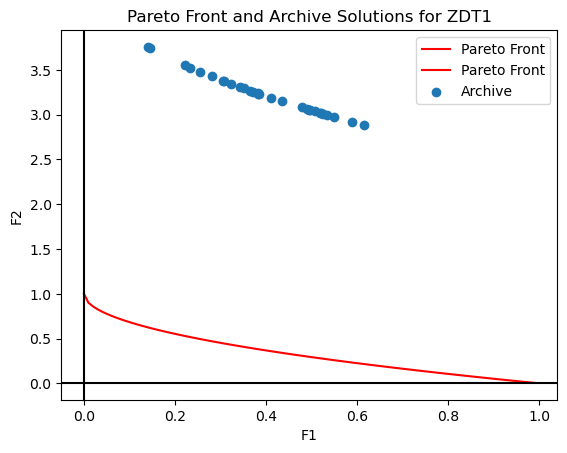

In [16]:
x = np.arange(0, 1, 0.01)
pareto_front_values = []

for xi in x:
    f1_val, f2_val = f1(np.array([xi, 0])), f2(np.array([xi, 0]))
    pareto_front_values.append([f1_val, f2_val])

pareto_front_values = np.array(pareto_front_values)
f1_values = pareto_front_values[:, 0]
f2_values = pareto_front_values[:, 1]

f1_arch = f1(arch)
f2_arch = f2(arch)

plt.plot(f1_values, f2_values, c="red", label="Pareto Front")  
plt.scatter(f1_arch, f2_arch, label="Archive")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.title("Pareto Front and Archive Solutions for ZDT1")
plt.show()

Kesimpulan : Algoritma ini menggunakan max archive iterasi 300 dengan max disetiap iterasi 50, max distance 0.5 dengan 30-variable problem masih value archive masih kurang maximal untuk mendekati pareto front yang ada

### Algoritma Pareto Archived Evolution Strategy yang dibuat masih belum bisa mengalahkan algoritma FSGA, NSGA-II, SPEA-2 PADA PERMASALAHAN ZDT1
Berikut papernya :  https://www.researchgate.net/publication/224309321_A_Multiobjective_Evolutionary-Simplex_Hybrid_Approach_for_the_Optimization_of_Differential_Equation_Models_of_Gene_Networks 

### MOP Menggunakan algoritma Pareto Archived Evolution Strategy
#### Permasalahan ZDT2 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from numpy.lib.scimath import sqrt

def f1(x):
    if len(x.shape) == 1:  # only one x observation
        return x
    else:
        return x


def f2(x):
    if len(x.shape) == 1:  # only one x observation
        n = len(x)
        g = 1 + (9 * np.sum(x[1:]) / (n - 1))
        h = 1 - np.power((f1(x) / g),2)
        return g * h
    else:
        n = x.shape[1]  # Number of elements in each row
        g = 1 + ((9 / (n - 1)) * np.sum(x[:, 1:], axis=1))
        h = 1 - np.power((f1(x) / g.reshape(-1, 1)),2)  # Ensure compatible shapes for broadcasting
        return g.reshape(-1, 1) * h


# return the relative fitness of an x value
# compared to the tournament x values: tourn_x,
# based off pareto dominance. Reward is based
# off strong and weak domination
def pareto_dominance(x, tourn_x):
    f_1 = f1(x)
    f_2 = f2(x)
    tourn_f1 = f1(tourn_x)
    tourn_f2 = f2(tourn_x)
    score = 0
    if len(tourn_x.shape) == 1:  # only one x observation
        if (f_1 <= tourn_f1).any() and (f_2 <= tourn_f2).any():  # atleast equal in any objectives
            score += 2
            if (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # strong dominance
                score += 2
        elif (f_1 < tourn_f1).any() and (f_2 < tourn_f2).any():  # weak domination
            score += 1
    else:
        for i in range(0, len(tourn_x)):
            for j in range(0, len(tourn_x)):
                if i == j:
                    continue
                for k in range(0, j):
                    pass

            for j in range(1, i):
                pass
            if (f_1 <= tourn_f1[i]).any() and (f_2 <= tourn_f2[i]).any():  # atleast equal in any objectives
                score += 2
                if (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # strong dominance
                    score += 2
            elif (f_1 < tourn_f1[i]).any() and (f_2 < tourn_f2[i]).any():  # weak domination
                score += 1

    return score


# Handles more than 2 parents
# Averaging Technique by taking mean of any parent values
def crossover_method_1(par):
    child = np.copy(par[0])
    for j in range(0, np.shape(par[0])[0]):
        child[j] = np.mean(par[:,j])
    return child


# Handles more than 2 parents
# 'intuitive' crossover by uniformly randomly
# inheriting genes from parents
def crossover_method_2(par):
    child = np.copy(par[0])
    n = np.shape(par[0])[0]
    # random indices from parents for child to inherit from
    random_nums = np.random.randint(low=0, high=len(par), size=n)
    for j in range(0, n):
        child[j] = par[random_nums[j]][j]
    return child


# classical Evolutionary Programming Mutation
# log-normal self adaptation
def mutate(par_val, par_sigma):
    n_x = len(par_val)  # number of variables
    tau = 1 / (np.sqrt(2 * np.sqrt(n_x)))
    tau_prime = 1 / (np.sqrt(2 * n_x))
    r = np.random.normal(0, 1, len(par_sigma))
    ch_sigma = par_sigma*np.exp(tau*r+tau_prime*r)
    r = np.random.normal(0, 1, len(par_sigma))
    ch_val = np.copy(par_val)+ch_sigma*r
    return ch_val, ch_sigma


# given a set of parents, their sigma, and cross_method
# produce two offspring, one through crossover only
# and the other through mutation after crossover
# choose the best for survival based off pareto-dominance
def reproduction(par, sigma, cross_method):
    if cross_method == 1:
        child_val = crossover_method_1(par)
        child_sigma = crossover_method_1(sigma)
    else:
        child_val = crossover_method_2(par)
        child_sigma = crossover_method_2(sigma)
    # mutate crossover offspring
    mut_child_val, mut_child_sigma = mutate(child_val, child_sigma)
    # get pareto-dominance between offspring
    f = pareto_dominance(child_val, mut_child_val)
    if f == 4:  # strong domination
        return child_val, child_sigma
    elif f == 2:  # weak domination
        r = np.random.uniform(0, 1, 1)
        if r < 0.5:  # randomly select winner
            return child_val, child_sigma
        else:
            return mut_child_val, mut_child_sigma
    else:  # no domination
        return mut_child_val, mut_child_sigma


# function has been parameterized for our problem, so no initial gen given
# size is # of individuals, var_count is number of variables for our problem
# max_distance is max euclidean similarity distance anyowed for solutions,
# max_iter is max iter of inner loop, archive_iter is outer loop -> larger
# iter for archive creates a bigger pareto-front
def evolutionary_strategy_pareto_algorithm(size, var_count, max_distance=2.0, max_iter=50,
                                           cross_method=1, par_count=2, archive_iter=30):

    lower_bound = [0] * var_count
    upper_bound = [1] * var_count
    bounds = [upper_bound, lower_bound]
    archive = []
    # outer loop
    for q in range(0, archive_iter):
        # create initial generation with strategy parameters
        init_gen = np.empty(shape=(size, var_count))
        init_sigma = np.empty(shape=(size, var_count))
        for i in range(0, var_count):
            init_sigma[:, i] = np.random.uniform(0.5, 5, size)
            init_gen[:, i] = np.random.uniform(0, 1, size)
        n, c = init_gen.shape
        tourn_size = int(0.05 * n)

        print("Archive {}".format(q + 1))
        gen = np.copy(init_gen)
        sigma = np.copy(init_sigma)
        # inner loop
        for k in range(0, max_iter):

            # random selection based off number of parents
            selected = []
            for i in range(0, par_count):
                selected.append(np.random.choice(range(0, n), n, replace=False))
            selected = np.asarray(selected).T
            ch_val = []
            ch_sigma = []
            # reproduce from parents
            '''
            if q % 2 == 0:
                cross_method = 1
            else:
                cross_method = 2
            '''
            for i in range(0, n):
                c_v, c_s = reproduction(gen[selected[i]], sigma[selected[i]], cross_method)
                ch_val.append(c_v)
                ch_sigma.append(c_s)

            ch_val = np.asarray(ch_val)
            ch_sigma = np.asarray(ch_sigma)
            # check bounds of offspring
            for i in range(0, n):
                for j in range(0, c):
                    if ch_val[i][j] > bounds[0][j]:
                        ch_val[i][j] = bounds[0][j]
                        ch_sigma[i][j] *= .90
                    elif ch_val[i][j] < bounds[1][j]:
                        ch_val[i][j] = bounds[1][j]
                        ch_sigma[i][j] *= .90

            # combine offspring with parents
            parents_offspring_val = np.vstack((gen, ch_val))
            parents_offspring_sigma = np.vstack((sigma, ch_sigma))
            ind = list(range(0, 2*n))
            rel_fit = []
            # compute relative fitness
            for i in range(0, 2*n):
                tourn = np.random.choice(ind[0:i]+ind[(i+1):], tourn_size)
                rel_fit.append(pareto_dominance(parents_offspring_val[i], parents_offspring_val[tourn]))

            if q != 0:  # not first iteration of outer loop
                # loop over each member in archive
                for arch in archive:
                    for i in range(0, 2*n):
                        # calculate euclidean distance
                        dist = np.linalg.norm(arch-parents_offspring_val[i])
                        # if their distance is smany -> they're too close,
                        # larger the max distance the more spread out solutions become
                        if dist <= max_distance:
                            # penalize fitness down to 25%
                            rel_fit[i] *= 0.25

            # sort individuals based on relative fitness
            rel_fit = np.asarray(rel_fit)
            sorted_ind = np.asarray(ind)[np.argsort(-rel_fit)]

            # use elitism to take the best half from pooled
            # parents and offspring
            gen = parents_offspring_val[sorted_ind[0:n]]
            sigma = parents_offspring_sigma[sorted_ind[0:n]]

            # calculate best for printing out information
            fit_f1 = f1(gen)
            fit_f2 = f2(gen)
            fit_best_f1 = np.min(fit_f1)
            fit_mean_f1 = np.mean(fit_f1)
            fit_best_f2 = np.min(fit_f2)
            fit_mean_f2 = np.mean(fit_f2)
            msg = "GENERATION {}:\n" \
                  " F1: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n"\
                  " F2: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n".format(k, fit_best_f1, fit_mean_f1, fit_best_f2, fit_mean_f2)
            print(msg)

        # update archive
        if q != 0:
            # loop over every individual in surviving generation
            for j in range(0, len(gen)):
                # indices of members in archive that are dominated by
                # the current individual
                ind_del = []
                f1_arch = f1(np.asarray(archive))
                f2_arch = f2(np.asarray(archive))
                dominated = False
                for i in range(0, len(archive)):
                    # individual strongly dominates member of archive
                    if (f1_arch[i] > fit_f1[j]).any() and (f2_arch[i] > fit_f2[j]).any():
                        ind_del.append(i)  # add member index for deletion
                    # individual is strongly dominated by member
                    elif (f1_arch[i] < fit_f1[j]).any() and (f2_arch[i] < fit_f2[j]).any():
                        dominated = True
                if len(ind_del) != 0:
                    # delete members that are strongly dominated
                    for index in sorted(ind_del, reverse=True):
                        del archive[index]
                if not dominated:  # weakly dominates members of archive
                    archive.append(gen[j])

        else:  # if first iteration of outer loop, just add best solution from gen
            archive.append(gen[0])
    print(archive)
    return np.asarray(archive)

arch = evolutionary_strategy_pareto_algorithm(size=100, var_count=30, max_distance=0.75,
                                              max_iter=40, cross_method=1, par_count=3,
                                              archive_iter=50)

Archive 1
GENERATION 0:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4577831073269186
 F2: 
  Best Fit: 3.9226191646741304, Mean Fit: 5.027599284954313

GENERATION 1:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.43252345215191684
 F2: 
  Best Fit: 3.409377131572829, Mean Fit: 4.789299370935525

GENERATION 2:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.41681732426992235
 F2: 
  Best Fit: 3.409377131572829, Mean Fit: 4.647167930498427

GENERATION 3:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.4005446381211064
 F2: 
  Best Fit: 3.3572125435695352, Mean Fit: 4.505075013551183

GENERATION 4:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.3828495401398491
 F2: 
  Best Fit: 2.851215465911249, Mean Fit: 4.3618588874778075

GENERATION 5:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.3703255234701061
 F2: 
  Best Fit: 2.851215465911249, Mean Fit: 4.252878104557846

GENERATION 6:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.3602537553577563
 F2: 
  Best Fit: 2.851215465911249, Mean Fit: 4.165089618361932

GENERATION 7:
 F1: 
  Best Fit: 0.0, Mean Fit: 0.350316883449

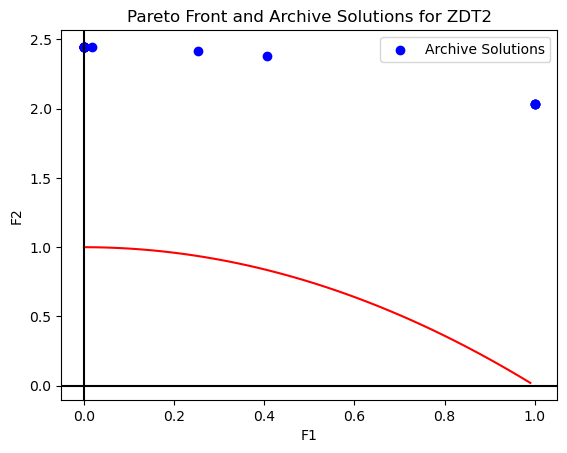

In [38]:
x = np.arange(0, 1, 0.01)
y = np.array([[f1(np.array([xi] + [0] * 29)), f2(np.array([xi] + [0] * 29))] for xi in x])


f1_values = [val[0] for val in y]
f2_values = [val[1] for val in y]
plt.plot(f1_values, f2_values, c="red")

archive_f1 = [f1(sol) for sol in arch]
archive_f2 = [f2(sol) for sol in arch]
plt.scatter(archive_f1, archive_f2, label="Archive Solutions", c="blue")

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.title("Pareto Front and Archive Solutions for ZDT2")
plt.show()

Kesimpulan : Algoritma ini menggunakan max archive iterasi 50 dengan max distance 0.75 dengan 30-variable problem masih value archive masih kurang maximal untuk mendekati pareto front yang ada

### Algoritma Pareto Archived Evolution Strategy yang dibuat masih bisa lebih baik daripada algoritma NSGA-II dab SPEA-2 akan tetapi masih belum bisa mengalahkan algoritma FSGA PADA PERMASALAHAN ZDT2
Berikut papernya :  https://www.researchgate.net/publication/224309321_A_Multiobjective_Evolutionary-Simplex_Hybrid_Approach_for_the_Optimization_of_Differential_Equation_Models_of_Gene_Networks 

### Berikut Contoh Penerapan NSGA-II pada Permasalahan Himmelblau

### MOP Menggunakan algoritma NSGA-II
Non-dominated Sorting Genetic Algorithm Pada Permasalahan Himmelblau mencari falue x dan y atau x[0] dan x[1]

Menjalankan NSGA-II...
Last Generation...
[[-2.8003879514734464, 3.137521989631886], [-2.8003879514734464, 3.137521989631886], [-1.8388490852794053, 3.5778514889158695], [-1.8388490852794053, 3.5778514889158695], [-2.735895063020081, 3.2030319375122875], [-2.6159163825081837, 3.237625463590803], [-2.3127168563848217, 3.3245624454544833], [-2.53434126833963, 3.251222239657178], [-2.25012903383906, 3.471068633935455], [-2.4064191923220943, 3.2989292600886913], [-2.3127168563848217, 3.3245624454544833], [-2.7562803748121927, 3.161062779603178], [-2.7321225339311943, 3.15760100874018], [-2.355039222288182, 3.4607906011006206], [-1.8983190382787334, 3.577871802386934], [-2.4345834778308744, 3.40276739053793], [-2.5028901403599524, 3.263440946259392], [-2.3563398604031245, 3.2753863992388466], [-1.9830944943890587, 3.5536279050704374], [-2.355039222288182, 3.4607906011006206], [-2.6678869413977546, 3.224024640595001], [-2.521464564781572, 3.3793320928477866], [-1.987935545402644, 3.528524451

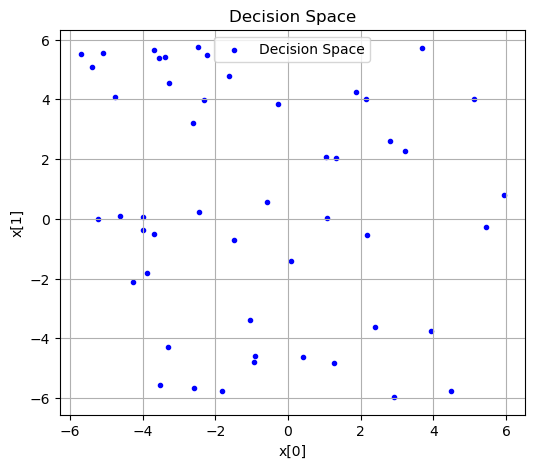

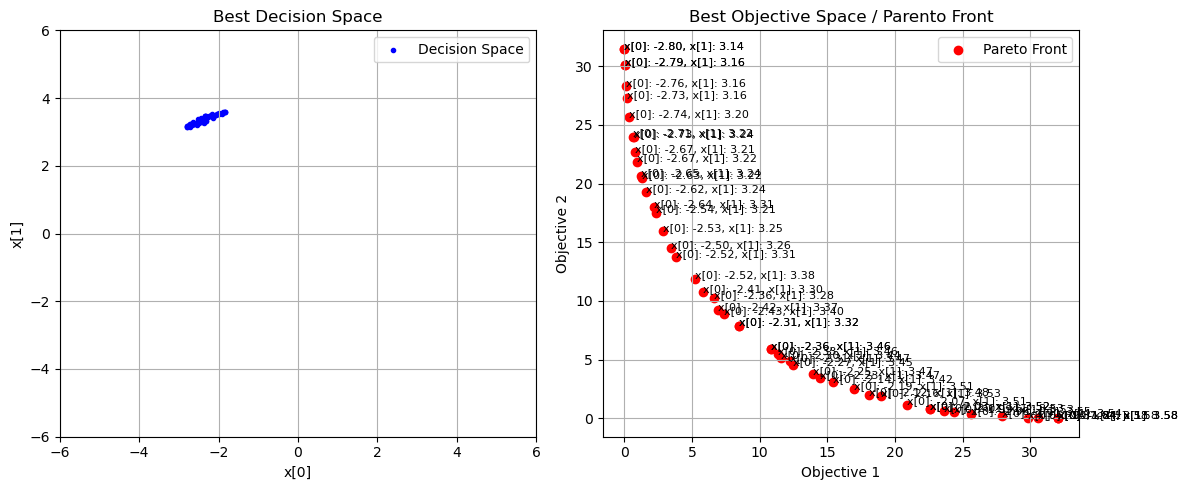

In [17]:
import random
import numpy as np
from deap import base, creator, tools
import matplotlib.pyplot as plt

# Definisi fungsi Himmelblau
def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def plot_decision_space(decision_space):
    plt.figure(figsize=(6, 5))
    x = [ind[0] for ind in decision_space]
    y = [ind[1] for ind in decision_space]
    plt.scatter(x, y, c='blue', marker='.', label='Decision Space')
    plt.title('Decision Space')
    plt.xlabel('x[0]')
    plt.ylabel('x[1]')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_objective_space(pareto_front):
    x_objective = [ind.fitness.values[0] for ind in pareto_front]
    y_objective = [ind.fitness.values[1] for ind in pareto_front]

    x_decision = [ind[0] for ind in pareto_front]
    y_decision = [ind[1] for ind in pareto_front]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(x_decision, y_decision, c='blue', marker='.', label='Decision Space')
    plt.title('Best Decision Space')
    plt.xlabel('x[0]')
    plt.ylabel('x[1]')
    plt.xlim([-6, 6])
    plt.ylim([-6, 6])
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(x_objective, y_objective, c='red', label='Pareto Front')
    for i, (x, y) in enumerate(zip(x_decision, y_decision)):
        plt.text(x_objective[i], y_objective[i], f'x[0]: {x:.2f}, x[1]: {y:.2f}', fontsize=8)
    plt.title('Best Objective Space / Parento Front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Mendefinisikan ruang pencarian
toolbox.register("attr_float", random.uniform, -6, 6)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Mendefinisikan fungsi evaluasi (objective function)
toolbox.register("evaluate", lambda x: (himmelblau(x), himmelblau(x[::-1])))  # Mengembalikan dua nilai untuk dua tujuan

# Mendefinisikan operator untuk evolusi
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

def main():
    population = toolbox.population(n=50)
    CXPB, MUTPB, NGEN = 0.7, 0.2, 100
    decision_space = []
    print("Menjalankan NSGA-II...")
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
        decision_space.append(ind)

    for gen in range(NGEN):
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = toolbox.select(population + offspring, len(population))

    print("Last Generation...")
    print(population)

    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
    print("Pareto Front:")
    print(pareto_front)

    plot_decision_space(decision_space)
    plot_objective_space(pareto_front)


if __name__ == "__main__":
    main()